In [1]:
import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns
sns.set()

import numpy as np

import multiprocessing as mp

from tqdm import tqdm

import os

from functools import partial

import pandas as pd

%load_ext autoreload 

Populating the interactive namespace from numpy and matplotlib


# Heavy-tails and outliers robustness

In [2]:
%autoreload
from ucb_classes import lilUCB, robust_lilUCB
from mab_class import MAB

In [3]:
def lilUCB_exp(scenario, distrib, K, α=.3, σ=.5): 
    
    np.random.seed()
    
    mab = MAB(K, scenario, distrib, α=α)
        
    lilUCB_proc = lilUCB(K=K, ν=.1, β=1, σ=σ)
    
    T = lilUCB_proc.run(mab)
    
    return np.sum(T), np.argmax(T)

def robust_lilUCB_exp(scenario, distrib, K, α=.3, σ=1.):
    
    np.random.seed()
    
    mab = MAB(K, scenario, distrib, α=α)
    
    robust_lilUCB_proc = robust_lilUCB(K=K, ν=.1, β=1, σ=σ)
    
    T = robust_lilUCB_proc.run(mab)
    
    return np.sum(T), np.argmax(T)

In [4]:
import logging

from logging.handlers import RotatingFileHandler
 
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(message)s')

file_handler = RotatingFileHandler('activity.log', 'a', 1000000, 1)

file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [5]:
list_of_K = np.logspace(1, 8, 8, base=2, dtype=int)

n_exp = len(list_of_K)
n_rep = 200

if 'BAI_lilUCB.npy' not in os.listdir('experiments_results'):

    BAI_lilUCB = np.zeros((n_exp, n_rep), dtype=int)
    BAI_robustlilUCB = np.zeros((n_exp, n_rep), dtype=int)
    BAI_lilUCB_huber = np.zeros((n_exp, n_rep), dtype=int)
    BAI_robustlilUCB_huber = np.zeros((n_exp,n_rep), dtype=int)
    BAI_lilUCB_student = np.zeros((n_exp, n_rep), dtype=int)
    BAI_robustlilUCB_student = np.zeros((n_exp,n_rep), dtype=int)

    nb_of_pulls_lilUCB = np.zeros((n_exp, n_rep), dtype=int)
    nb_of_pulls_robustlilUCB = np.zeros((n_exp, n_rep), dtype=int)
    nb_of_pulls_lilUCB_huber = np.zeros((n_exp, n_rep), dtype=int)
    nb_of_pulls_robustlilUCB_huber = np.zeros((n_exp, n_rep), dtype=int)
    nb_of_pulls_lilUCB_student = np.zeros((n_exp, n_rep), dtype=int)
    nb_of_pulls_robustlilUCB_student = np.zeros((n_exp, n_rep), dtype=int)
else:
    BAI_lilUCB = np.load('experiments_results/BAI_lilUCB.npy')  
    BAI_robustlilUCB = np.load('experiments_results/BAI_robustlilUCB.npy')  
    BAI_lilUCB_huber = np.load('experiments_results/BAI_lilUCB_huber.npy')  
    BAI_robustlilUCB_huber = np.load('experiments_results/BAI_robustlilUCB_huber.npy')  
    BAI_lilUCB_student = np.load('experiments_results/BAI_lilUCB_student.npy') 
    BAI_robustlilUCB_student = np.load('experiments_results/BAI_robustlilUCB_student.npy') 

    nb_of_pulls_lilUCB = np.load('experiments_results/nb_of_pulls_lilUCB.npy')  
    nb_of_pulls_robustlilUCB = np.load('experiments_results/nb_of_pulls_robustlilUCB.npy')
    nb_of_pulls_lilUCB_huber = np.load('experiments_results/nb_of_pulls_lilUCB_huber.npy')
    nb_of_pulls_robustlilUCB_huber = np.load('experiments_results/nb_of_pulls_robustlilUCB_huber.npy')
    nb_of_pulls_lilUCB_student = np.load('experiments_results/nb_of_pulls_lilUCB_student.npy')
    nb_of_pulls_robustlilUCB_student = np.load('experiments_results/nb_of_pulls_robustlilUCB_student.npy')

In [ ]:
# initialization of pooled
p = mp.Pool(mp.cpu_count())

for i, K in enumerate(tqdm(list_of_K)): 

    if (nb_of_pulls_robustlilUCB[i, :]==0).all():
    
        # Gaussian model
        scenario, distrib = 'alpha', 'gaussian'

        logger.info('Starting lilUCB procedure for {} arms'.format(K))

        # lilUCB 
        f = partial(lilUCB_exp, scenario, distrib)
        result = np.array(p.map_async(f, [K]*n_rep).get())
        nb_of_pulls_lilUCB[i, :] = result[:,  0]
        BAI_lilUCB[i, :] = result[:, 1]

        logger.info('Starting median lilUCB procedure for {} arms'.format(K))

        # robust lil UCB
        f = partial(robust_lilUCB_exp, scenario, distrib)
        result = np.array(p.map_async(f, [K]*n_rep).get())
        nb_of_pulls_robustlilUCB[i, :] = result[:, 0]
        BAI_robustlilUCB[i, :] = result[:, 1]

        # Huber model (Cauchy/Gaussian mixture)

        scenario, distrib = 'alpha', 'cauchy_gaussian_mixture'

        logger.info('Starting lilUCB procedure for {} arms (Huber)'.format(K))

        # lilUCB contaminated 
        f = partial(lilUCB_exp, scenario, distrib)
        result = np.array(p.map_async(f, [K]*n_rep).get())
        nb_of_pulls_lilUCB_huber[i, :] = result[:, 0]
        BAI_lilUCB_huber[i, :] = result[:, 1]

        logger.info('Starting median lilUCB procedure for {} arms (Huber)'.format(K))

        # robust lilUCB contaminated 
        f = partial(robust_lilUCB_exp, scenario, distrib)
        result = np.array(p.map_async(f, [K]*n_rep).get())
        nb_of_pulls_robustlilUCB_huber[i, :] = result[:,0]
        BAI_robustlilUCB_huber[i, :] = result[:, 1]

        # Student mis-specification

        scenario, distrib = 'alpha', 'student2'

        logger.info('Starting lilUCB procedure for {} arms (Student)'.format(K))

        # lilUCB Student mis-specification 
        f = partial(lilUCB_exp, scenario, distrib)
        result = np.array(p.map_async(f, [K]*n_rep).get())
        nb_of_pulls_lilUCB_student[i, :] = result[:, 0]
        BAI_lilUCB_student[i, :] = result[:, 1]

        logger.info('Starting median lilUCB procedure for {} arms (Student)'.format(K))

        # robust lilUCB student mis-specification 
        f = partial(robust_lilUCB_exp, scenario, distrib)
        result = np.array(p.map_async(f, [K]*n_rep).get())
        nb_of_pulls_robustlilUCB_student[i, :] = result[:,0]
        BAI_robustlilUCB_student[i, :] = result[:, 1]


        logger.info("Finished task, saving results...")

        np.save('experiments_results/BAI_lilUCB.npy', BAI_lilUCB)
        np.save('experiments_results/BAI_robustlilUCB.npy', BAI_robustlilUCB) 
        np.save('experiments_results/BAI_lilUCB_huber.npy', BAI_lilUCB_huber) 
        np.save('experiments_results/BAI_robustlilUCB_huber.npy', BAI_robustlilUCB_huber)
        np.save('experiments_results/BAI_lilUCB_student.npy', BAI_lilUCB_student) 
        np.save('experiments_results/BAI_robustlilUCB_student.npy', BAI_robustlilUCB_student) 

        np.save('experiments_results/nb_of_pulls_lilUCB.npy', nb_of_pulls_lilUCB)
        np.save('experiments_results/nb_of_pulls_robustlilUCB.npy', nb_of_pulls_robustlilUCB)
        np.save('experiments_results/nb_of_pulls_lilUCB_huber.npy', nb_of_pulls_lilUCB_huber)
        np.save('experiments_results/nb_of_pulls_robustlilUCB_huber.npy', nb_of_pulls_robustlilUCB_huber)
        np.save('experiments_results/nb_of_pulls_lilUCB_student.npy', nb_of_pulls_lilUCB_student)
        np.save('experiments_results/nb_of_pulls_robustlilUCB_student.npy', nb_of_pulls_robustlilUCB_student)

p.close()

 62%|██████▎   | 5/8 [4:29:03<2:41:26, 3228.72s/it]

In [26]:
list_of_K = np.logspace(1, 3, 3, base=2, dtype=int)

In [32]:
prop_1 = np.sum(BAI_lilUCB[:3,:]==0, axis=1)/n_rep
prop_2 = np.sum(BAI_robustlilUCB[:3,:]==0, axis=1)/n_rep

prop_3 = np.sum(BAI_lilUCB_huber[:3,:]==0, axis=1)/n_rep
prop_4 = np.sum(BAI_robustlilUCB_huber[:3,:]==0, axis=1)/n_rep

prop_5 = np.sum(BAI_lilUCB_student[:3,:]==0, axis=1)/n_rep
prop_6 = np.sum(BAI_robustlilUCB_student[:3,:]==0, axis=1)/n_rep


tuples = [("Gaussian", "lil'UCB"), ("Gaussian", "Median lil'UCB"), 
          ("Huber", "lil'UCB"), ("Huber", "Median lil'UCB"),
         ("Student", "lil'UCB"), ("Student", "Median lil'UCB")]
index = pd.MultiIndex.from_tuples(tuples, names=['Scenario', 'Algorithm'])
columns = ["K={}".format(K) for K in list_of_K]

df = pd.DataFrame(np.vstack([prop_1, prop_2, prop_3, prop_4, prop_5, prop_6]), index=index, columns=columns)
df.to_latex(buf="experiments_results/prop_BAI_huber.tex", multirow=True)
df

K=2    K=4    K=8
Scenario Algorithm                          
Gaussian lil'UCB         1.000  1.000  1.000
         Median lil'UCB  1.000  1.000  1.000
Huber    lil'UCB         0.915  0.820  0.750
         Median lil'UCB  1.000  1.000  1.000
Student  lil'UCB         0.915  0.975  0.915
         Median lil'UCB  1.000  1.000  1.000

In [33]:
sns.set_style("white", {'ytick.left':True, 'xtick.bottom':True})
n = np.logspace(2, 20, 200)

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

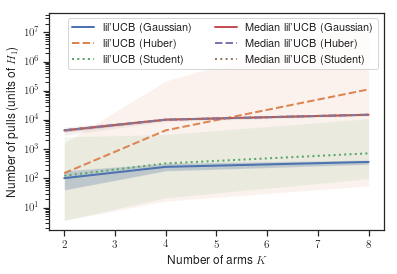

In [34]:
## sns.set()

# grid for both axis
plt.rcParams["axes.grid.axis"] ='both'

H_1 = [3*K/2 for K in list_of_K]

# lilUCB, Gaussian model
plt.semilogy(list_of_K, np.mean(nb_of_pulls_lilUCB[:3,:], axis=1)/H_1, 
           linewidth=2, linestyle='-', label="lil'UCB (Gaussian)")
plt.fill_between(list_of_K, np.min(nb_of_pulls_lilUCB[:3,:], axis=1)/H_1, 
                 np.max(nb_of_pulls_lilUCB[:3,:], axis=1)/H_1, alpha=0.3)

# lilUCB, mixture model
plt.semilogy(list_of_K, np.mean(nb_of_pulls_lilUCB_huber[:3,:], axis=1)/H_1, 
           linewidth=2, linestyle='--', label="lil'UCB (Huber)")
plt.fill_between(list_of_K, np.min(nb_of_pulls_lilUCB_huber[:3,:], axis=1)/H_1, 
                 np.max(nb_of_pulls_lilUCB_huber[:3,:], axis=1)/H_1, alpha=0.1)

# lilUCB, student misspecification model
plt.semilogy(list_of_K, np.mean(nb_of_pulls_lilUCB_student[:3,:], axis=1)/H_1, 
           linewidth=2, linestyle=':', label="lil'UCB (Student)")
plt.fill_between(list_of_K, np.min(nb_of_pulls_lilUCB_student[:3,:], axis=1)/H_1, 
                 np.max(nb_of_pulls_lilUCB_student[:3,:], axis=1)/H_1, alpha=0.1)

# robust lilUCB, Gaussian model
plt.semilogy(list_of_K, np.mean(nb_of_pulls_robustlilUCB[:3,:], axis=1)/H_1, 
           linewidth=2, linestyle='-', label="Median lil'UCB (Gaussian)")
plt.fill_between(list_of_K, np.min(nb_of_pulls_robustlilUCB[:3,:], axis=1)/H_1, 
                 np.max(nb_of_pulls_robustlilUCB[:3,:], axis=1)/H_1, alpha=0.3)

# robust lilUCB, mixture model
plt.semilogy(list_of_K, np.mean(nb_of_pulls_robustlilUCB_huber[:3,:], axis=1)/H_1, 
           linewidth=2, linestyle='--', label="Median lil'UCB (Huber)")
plt.fill_between(list_of_K, np.min(nb_of_pulls_robustlilUCB_huber[:3,:], axis=1)/H_1, 
                 np.max(nb_of_pulls_robustlilUCB_huber[:3,:], axis=1)/H_1, alpha=0.1)


# robust lilUCB, student misspecification model
plt.semilogy(list_of_K, np.mean(nb_of_pulls_robustlilUCB_student[:3,:], axis=1)/H_1, 
           linewidth=2, linestyle=':', label="Median lil'UCB (Student)")
plt.fill_between(list_of_K, np.min(nb_of_pulls_robustlilUCB_student[:3,:], axis=1)/H_1, 
                 np.max(nb_of_pulls_robustlilUCB_student[:3,:], axis=1)/H_1, alpha=0.1)

plt.xlabel('Number of arms $K$')
plt.ylabel('Number of pulls (units of $H_1$)')
plt.legend(ncol=2)
savefig('experiments_results/number_of_pulls_alpha.pdf', bbox_inches='tight', dpi=500)